# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель проекта**  
Найти самый перспективно выгодный регион для разработки новых скважин.

**Данные геологоразведки трёх регионов:**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


**Инструкция по выполнению проекта**  
1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона:
   2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
   2.2.Обучите модель и сделайте предсказания на валидационной выборке.
   2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
   2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели. 
   2.5. Проанализируйте результаты.
3. Подготовьтесь к расчёту прибыли:
   3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.
   3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
   3.3. Напишите выводы по этапу подготовки расчёта прибыли.
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
   4.1. Выберите скважины с максимальными значениями предсказаний.
   4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
   4.3. Рассчитайте прибыль для полученного объёма сырья.
5. Посчитайте риски и прибыль для каждого региона:
   5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
   5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

**Условия задачи:**  
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.  

## Загрузка и подготовка данных

### Импорт необходимых библиотек

In [1]:
!pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import phik

from phik.report import plot_correlation_matrix

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy import stats as st

from tqdm import tqdm

Загрузим данные

In [3]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

### Анализ данных 

#### Информация и размеры датафреймов

**Регион 1**

In [4]:
print('Первые строки:')
display(df_1.head())
print('Описание df')
display(df_1.describe())
print('')
print('Размер df:', df_1.shape)

Первые строки:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Описание df


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Размер df: (100000, 5)


**Регион 2**

In [5]:
print('Первые строки:')
display(df_2.head())
print('Описание df')
display(df_2.describe())
print('')
print('Размер df:', df_2.shape)

Первые строки:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Описание df


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Размер df: (100000, 5)


**Регион 3**

In [6]:
print('Первые строки:')
display(df_3.head())
print('Описание df')
display(df_3.describe())
print('')
print('Размер df:', df_3.shape)

Первые строки:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Описание df


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Размер df: (100000, 5)


#### Пропуски

**Регион 1**

In [7]:
pd.DataFrame(round(df_1.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


**Регион 2**

In [8]:
pd.DataFrame(round(df_2.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


**Регион 3**

In [9]:
pd.DataFrame(round(df_3.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


Пропусков нет - супер)

#### Дубликаты

##### Явные

In [10]:
print(df_1.duplicated().value_counts())
print(df_2.duplicated().value_counts())
print(df_3.duplicated().value_counts())

False    100000
dtype: int64
False    100000
dtype: int64
False    100000
dtype: int64


##### Неявные

In [11]:
print(df_1['id'].value_counts().head())
print(df_2['id'].value_counts().head())
print(df_3['id'].value_counts().head())

AGS9W    2
74z30    2
bsk9y    2
QcMuo    2
HZww2    2
Name: id, dtype: int64
wt4Uk    2
5ltQ6    2
bfPNe    2
LHZR0    2
nunjJ    1
Name: id, dtype: int64
Vcm5J    2
xCHr8    2
KUPhW    2
VF7Jo    2
MiKlG    1
Name: id, dtype: int64


Так-так.. Выведем пару строк с дублирующими названиями скважин

In [12]:
print(df_1.query('id == "QcMuo"'))
print()
print(df_2.query('id == "UqDnB"'))
print()
print(df_3.query('id=="Vcm5J"'))


          id        f0        f1        f2    product
1949   QcMuo  0.506563 -0.323775 -2.215583  75.496502
63593  QcMuo  0.635635 -0.473422  0.862670  64.578675

          id        f0        f1        f2     product
77100  UqDnB  8.241054 -2.897762  3.995774  107.813044

          id        f0        f1        f2     product
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572


По одним и тем же скважинам данные разнятся. Так как мы не знаем что означают эти данные, оставим их. Тем более что их очень мало (в каждм df по 4-5 пар - это 0,01%).

#### Корреляция Phik (которая вернет корреляцию Пирсона в случае двумерного нормального распределения входных данных).

**Регион 1**

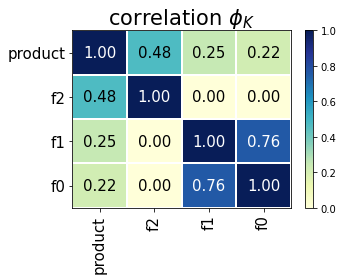

In [13]:
df_prep_1 = df_1.drop('id', axis=1)
interval_cols = ['f0', 'f1', 'f2', 'product']
phik_overview_1 = df_prep_1.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview_1.values, 
                        x_labels=phik_overview_1.columns, 
                        y_labels=phik_overview_1.index, 
                        vmin=0, vmax=1, color_map="YlGnBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(5, 4))


**Регион 2**

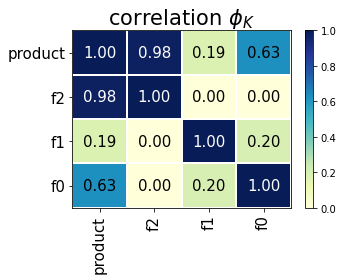

In [14]:
df_prep_2 = df_2.drop('id', axis=1)
phik_overview_2 = df_prep_2.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview_2.values, 
                        x_labels=phik_overview_2.columns, 
                        y_labels=phik_overview_2.index, 
                        vmin=0, vmax=1, color_map="YlGnBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(5, 4))


**Регион 3**

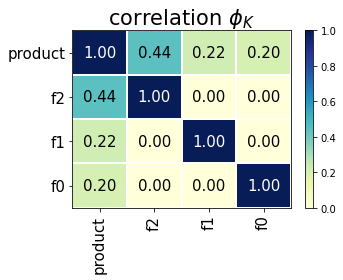

In [15]:
df_prep_3 = df_3.drop('id', axis=1)
phik_overview_3 = df_prep_3.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview_3.values, 
                        x_labels=phik_overview_3.columns, 
                        y_labels=phik_overview_3.index, 
                        vmin=0, vmax=1, color_map="YlGnBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(5, 4))


Показатели корреляции регионов 1 и 3 похожи, больше всего зависит целевой признак product от признака f2. В первом регионе есть сильная корреляция от признаков f1 и f0 = 0,76.  
В регионе 2 заметна очень сильная взаимосвязь product от признака f2, 0.98. Это может быть связано с тем, что данные синтетические, в реальной жизни такой коэффициент корреляции сложно представить. Также сильная корреляция во втором регионе целевого признака product от признака f0 = 0,63.

### Вывод:

- импортировали все необходимые инструменты,
- загрузили датасеты и ознакомились с ними,
- выявили подозрительную особенность - во всех трех датасетах имеются наблюдения о скважинах с одинаковым именем, но разными значениями признаков, оставили эти строки.
- проверили коэффициент корреляции:
    - показатели корреляции регионов 1 и 3 похожи, 
    - в первом регионе product и f2 =0.48, f1 и f0 =0.76,
    - во втором регионе product и f0 =0.63, product и f2 =0.98,
    - в тертьем регионе product и f2 =0.44.

## Обучение и проверка модели

### Разбивка данных

Выделим целевой признак в переменную `target`, а остальные в `features`

In [16]:
features_1 = df_prep_1.drop(['product'], axis=1)
target_1 = df_prep_1['product']

features_2 = df_prep_2.drop(['product'], axis=1)
target_2 = df_prep_2['product']

features_3 = df_prep_3.drop(['product'], axis=1)
target_3 = df_prep_3['product']

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25, рандомно перетасовав и равномерно распределив по целевому признаку..

**Регион 1**

In [17]:
features_train_1, features_val_1, target_train_1, target_val_1 = train_test_split(features_1, target_1, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345
                                                                                  )

print("Количество строк в train:", target_train_1.shape)
print("Количество строк в test:", target_val_1.shape)

Количество строк в train: (75000,)
Количество строк в test: (25000,)


**Регион 2**

In [18]:
features_train_2, features_val_2, target_train_2, target_val_2 = train_test_split(features_2, target_2, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345
                                                                                  )

print("Количество строк в train:", target_train_2.shape)
print("Количество строк в test:", target_val_2.shape)

Количество строк в train: (75000,)
Количество строк в test: (25000,)


**Регион 3**

In [19]:
features_train_3, features_val_3, target_train_3, target_val_3 = train_test_split(features_3, target_3, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345
                                                                                    )

print("Количество строк в train:", target_train_3.shape)
print("Количество строк в test:", target_val_3.shape)

Количество строк в train: (75000,)
Количество строк в test: (25000,)


### Обучение модели и предсказания на валидационной выборке.

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

1. Обучим модель и сделаем предсказания на валидационной выборке.
2. Сохраним предсказания и правильные ответы на валидационной выборке в переменной predict_n *(где n - номер региона)*.
3. Напечатаем на экране средний запас предсказанного сырья (тыс.баррелей в скважине) и RMSE модели.
4. Проанализируем результаты.

**Регион 1**

In [20]:
model_1=LinearRegression()

scores_1 = cross_val_score(model_1, features_1, target_1, cv=5)
#получение метрики качества (R2) для каждого фолда  
print ('R2 региона на кросс-валидации:', scores_1)
# Среднее значение метрики и стандартное отклонение
print ('Средний R2 на кросс-валидации: %.2f'% scores_1.mean(), 'Стандартное отклонение: %.2f'% scores_1.std())

#обучение модели
model_1.fit(features_train_1, target_train_1)

#предсказание на валидационной выборке
predict_val_1 = model_1.predict(features_val_1)
#переведем в Series для дальнейшего использования
predict_val_1_ser = pd.Series(data=predict_val_1, index=target_val_1.index)

# RMSE для предсказаний на лучшем фолде кросс-валидации
rmse_1 = mean_squared_error(target_val_1, predict_val_1)**0.5

print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_1)
print('Средний запас предсказанного сырья в скважине: %.2f'% predict_val_1.mean())
print('Истинный средний запас: %.2f'% target_val_1.mean())

R2 региона на кросс-валидации: [0.27940755 0.26696976 0.27947874 0.28050446 0.27109602]
Средний R2 на кросс-валидации: 0.28 Стандартное отклонение: 0.01
Среднеквадратичная ошибка RMSE: 37.58
Средний запас предсказанного сырья в скважине: 92.59
Истинный средний запас: 92.08


**Регион 2**

In [21]:
model_2=LinearRegression()

scores_2 = cross_val_score(model_2, features_2, target_2, cv=5)
#получение метрики качества (R2) для каждого фолда  
print ('R2 региона на кросс-валидации:', scores_2)
# Среднее значение метрики и стандартное отклонение
print ('Средний R2 на кросс-валидации: %.2f'% scores_2.mean(), 'Стандартное отклонение: %.2f'% scores_2.std())

#обучение модели
model_2.fit(features_train_2, target_train_2)

#предсказание на валидационной выборке
predict_val_2 = model_2.predict(features_val_2)
#переведем в Series для дальнейшего использования
predict_val_2_ser = pd.Series(data=predict_val_2, index=target_val_2.index)

# RMSE для предсказаний на лучшем фолде кросс-валидации
rmse_2 = mean_squared_error(target_val_2, predict_val_2)**0.5

print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)
print('Средний запас предсказанного сырья в скважине: %.2f'% predict_val_2.mean())
print('Истинный средний запас: %.2f'% target_val_2.mean())


R2 региона на кросс-валидации: [0.99962905 0.99961947 0.99961951 0.9996311  0.99962274]
Средний R2 на кросс-валидации: 1.00 Стандартное отклонение: 0.00
Среднеквадратичная ошибка RMSE: 0.89
Средний запас предсказанного сырья в скважине: 68.73
Истинный средний запас: 68.72


**Регион 3**

In [22]:
model_3=LinearRegression()

scores_3 = cross_val_score(model_3, features_3, target_3, cv=5)
#получение метрики качества (R2) для каждого фолда  
print ('R2 региона на кросс-валидации:', scores_3)
# Среднее значение метрики и стандартное отклонение
print ('Средний R2 на кросс-валидации: %.2f'% scores_3.mean(), 'Стандартное отклонение: %.2f'% scores_3.std())

#обучение модели
model_3.fit(features_train_3, target_train_3)

#предсказание на валидационной выборке
predict_val_3 = model_3.predict(features_val_3)
#переведем в Series для дальнейшего использования
predict_val_3_ser = pd.Series(data=predict_val_3, index=target_val_3.index)
# RMSE для предсказаний на лучшем фолде кросс-валидации
rmse_3 = mean_squared_error(target_val_3, predict_val_3)**0.5

print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_3)
print('Средний запас предсказанного сырья в скважине: %.2f'% predict_val_3.mean())
print('Истинный средний запас: %.2f'% target_val_3.mean())

R2 региона на кросс-валидации: [0.19197954 0.19592695 0.19914376 0.20304226 0.20348561]
Средний R2 на кросс-валидации: 0.20 Стандартное отклонение: 0.00
Среднеквадратичная ошибка RMSE: 40.03
Средний запас предсказанного сырья в скважине: 94.97
Истинный средний запас: 94.88


Выведем на экран наши предсказания (среднне по скважине) и значения среднеквадратической ошибки

In [23]:
table = pd.DataFrame(index=['Средний запас предсказанного сырья в скважине','RMSE модели'], columns=['Регион 1','Регион 2','Регион 3'])
table['Регион 1'] = predict_val_1.mean(), rmse_1
table['Регион 2'] = predict_val_2.mean(), rmse_2
table['Регион 3'] = predict_val_3.mean(), rmse_3
table

,Регион 1,Регион 2,Регион 3
Средний запас предсказанного сырья в скважине,92.592568,68.728547,94.965046
RMSE модели,37.579422,0.893099,40.029709


### Вывод
1. Данные разбиты на обучающую и валидационную выборки в соотношении 75:25.
2. Модели обучены, предсказания на валидационной выборке сделаны.
3. Предсказания и правильные ответы на валидационной выборке сохранены в переменные predict_n и rmse_n *(где n - номер региона)*.
4. Средний запас предсказанного сырья по скважине и RMSE моделей выведены на экран.
5. Модели показали хорошие результаты, особенно для 2-го региона, где признак f2 сильно коррелирует с целевым.

## Подготовка к расчёту прибыли

### Сохранение в отдельных переменных всех ключевых значений 

При разведке региона исследуют **500 точек**, из которых с помощью машинного обучения выбирают **200 лучших** для разработки.   
**Бюджет** на разработку скважин в регионе — **10 млрд рублей**.  
При нынешних ценах **один баррель** сырья приносит **450 рублей** дохода. Доход с каждой единицы продукта составляет **450 тыс. рублей**, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых **вероятность убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.  

In [24]:
# количество исследуемых точек 
explore = 500
# колиечство скважин для разработки
drills = 200
# бюджет на разработку
budget = 10 * 10**9
# стоимость 1 барреля нефти
barrel_price = 450
# доход с 1000 баррелей нефти
product_income = barrel_price * 1000
# порог доли убытков
limit_pr = 2.5

Рассчитаем бюджет на разработку 1 скважины

In [25]:
budg_per_1_point=(budget/200) 
print('Бюджет на разработку одной скважины:', budg_per_1_point/1000000, 'млн. руб')

Бюджет на разработку одной скважины: 50.0 млн. руб


### Расчет объемов сырья

Рассчитаем объём сырья для безубыточной разработки скважины по региону

In [26]:
product_vol_reg = budget / product_income
print(product_vol_reg, 'тыс. баррелей в регионе')


22222.222222222223 тыс. баррелей в регионе


Рассчитаем объём сырья для безубыточной разработки скважины

In [27]:
product_vol_ow = product_vol_reg / drills
print(product_vol_ow, 'тыс. баррелей в скважине')

111.11111111111111 тыс. баррелей в скважине


In [28]:
print('Cредний запас сырья в скважине в 1 регионе: %.2f тыс.баррелей'%predict_val_1.mean())
print('Cредний запас сырья в скважине в 2 регионе: %.2f тыс.баррелей'%predict_val_2.mean())
print('Cредний запас сырья в скважине в 3 регионе: %.2f тыс.баррелей'%predict_val_3.mean())

Cредний запас сырья в скважине в 1 регионе: 92.59 тыс.баррелей
Cредний запас сырья в скважине в 2 регионе: 68.73 тыс.баррелей
Cредний запас сырья в скважине в 3 регионе: 94.97 тыс.баррелей


111,1 тыс. баррелей против даже самого большого среднего в тертьем регионе =94,96. Можно сделать вывод, что любой регион будет убыточным. Но у нас есть 500 исследуемых скважин для разработки, из которых мы можем выбрать 200 самых преспективных.

### Функция расчета прибыли

In [29]:
''' Функция получает на вход значения целевого признака и предсказания (предварительно преобразованные в список).
    Сортирует предсказания по убыванию.
    Отбирает наиболее релевантные для неё значения (первые 200, что равно нашему количеству скважин)
    и возвращает выручку равную сумме выбранных значений целевого признака (первые 200 по убыванию), 
    умноженную на стоимость 1 тыс. баррелей минус размер бюджета
'''
def calc_profit(target, prediction):
    preds_sorted = prediction.sort_values(ascending=False)
    selected = target[preds_sorted.index][:drills]
    return selected.sum() * product_income - budget

In [30]:
# Посчитаем прибыль по каждому региону
print('Предсказываемая прибыль для региона 1 = %.2f'% calc_profit(target_val_1, predict_val_1_ser));
print('Предсказываемая прибыль для региона 2 = %.2f'% calc_profit(target_val_2, predict_val_2_ser));
print('Предсказываемая прибыль для региона 3 = %.2f'% calc_profit(target_val_3, predict_val_3_ser));

Предсказываемая прибыль для региона 1 = 3320826043.14
Предсказываемая прибыль для региона 2 = 2415086696.68
Предсказываемая прибыль для региона 3 = 2710349963.60


### Вывод
Бюджет на разработку одной скважины: 50.0 млн. руб.  
Объём сырья для безубыточной разработки скважины 111.1 тыс. баррелей.  
  
У нас в среднем по регионам:  
     - в первом  - 92.59 тыс. баррелей  
     - во втором - 68.73 тыс. баррелей  
     - в третьем - 94.97 тыс. баррелей  
  
Однако максимальная предсказываемая прибыль в регионах:  
     - в первом  - 3.32 млрд. рублей  
     - во втором - 2.42 млрд. рублей  
     - в третьем - 2.71 млрд. рублей  
      
На данном этапе самый выгодный регон предположительно первый.

## Расчёт прибыли и рисков 

### Расчет
Посчитаем прибыль и риски для каждого региона:  
 - применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [31]:
state = np.random.RandomState(12345)

In [32]:
# Функция подсчета суммарной прибыли лучших 200 скважин из 500 для 1000 случайных выборок 

def ammout_profit(target, predict):
    
    values = []
    count = 0      # счетчик числа убыточных выборок
    
    for i in tqdm(range(1000)):    
        
        # Bootstrap
        target_subsample = target.sample(n=explore, replace=True, random_state=state)
        
        # Подсчет прибыли для выборки
        predicts_subsample = predict[target_subsample.index]
        
        # Создание распределения значений прибыли выборок
        values.append(calc_profit(target_subsample, predicts_subsample))
        
        # Подсчет убыточных выборок
#        if target_subsample < 0:
#            count += 1
    
    values = pd.Series(values)
    
    alpha_def = 0.95
    df = values.count() - 1
    confidence_interval = st.t.interval(alpha_def, df, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.01)
 
    mean = values.mean()
    print("Средняя прибыль:", mean)
    print("95% доверительный интервал (истинное среднее)", confidence_interval)
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    print("95% доверительный интервал (прогноз)", confidence_interval)
    
    loss_probability = values[values < 0].count() / values.count()
    print('Вероятность убытка = {:.2%}'.format(loss_probability))
    
    if (loss_probability <= limit_pr):
        print('Регион годится для разработки!')
    
    print()

In [33]:
print('Model for region 1');
ammout_profit(target_val_1, predict_val_1_ser)
print('Model for region 2');
ammout_profit(target_val_2, predict_val_2_ser)
print('Model for region 3');
ammout_profit(target_val_3, predict_val_3_ser)

Model for region 1


100%|██████████| 1000/1000 [00:01<00:00, 733.74it/s]


Средняя прибыль: 425938526.91059244
95% доверительный интервал (истинное среднее) (408732207.06869864, 443144846.7524862)
95% доверительный интервал (прогноз) (-102090094.83793654, 947976353.3583689)
Вероятность убытка = 6.00%
Регион годится для разработки!

Model for region 2


100%|██████████| 1000/1000 [00:01<00:00, 758.31it/s]


Средняя прибыль: 518259493.6973249
95% доверительный интервал (истинное среднее) (505249881.5766217, 531269105.81802803)
95% доверительный интервал (прогноз) (128123231.43308444, 953612982.0669085)
Вероятность убытка = 0.30%
Регион годится для разработки!

Model for region 3


100%|██████████| 1000/1000 [00:01<00:00, 764.66it/s]

Средняя прибыль: 420194005.3440501
95% доверительный интервал (истинное среднее) (402528703.65036154, 437859307.0377387)
95% доверительный интервал (прогноз) (-115852609.16001143, 989629939.8445739)
Вероятность убытка = 6.20%
Регион годится для разработки!



### Вывод
Регион в котором с 95% вероятностью прибыль превысит 505 млн. рублей и с самой низкой вероятностью убытков - регион номер 2. Рекомендуем его для разработки скважин.

## Вывод
1. Изучили данные, увидели большую корреляцию признков product и f2 во втором регионе.
2. Обучили модель, получив предварительные оценки модели и предсказаний по трем регионам
    - Второй регион показал худший средний результат предсказаний (68,73) и низкое значение RMSE
    - Первый и второй похожи друг на друга: среднее запаса предсказанного сырья в скважине: 92.08 и 94.97, RMSE 37.58 и 40.03 соответственно
3. Рассчитали прибыльность каждого региона по предсказанным данным (каждый регион оказался прибыльным, однако первый показал наибольший результат 3.320 млрд.)
4. Применили бутстрэп, чтобы оценить регион с разных точек и получили средние значения генеральной совокупности

Изучив эти данные, можем рекомендовать к разрабатке **второй регион**, т.к. он одновременно обеспечивает самую высокую среднюю прибыль (выше 505 миллионов) при минимальном риске в 0,3%
